# **Cosas que pasan juntas**

> Clustering para la detección de centralidades urbanas





<figure>
<center>
<img src='https://drive.google.com/uc?id=1QVx3I0_4uv7yA6DECpAo9VXJGvrq4og8' />
<figcaption></figcaption></center>
</figure>

Antes que nada, ¿qué entendemos por centralidad? Fundamentalmente, a aquellas actividades que suceden en un contexto de proximidad espacial. Es decir, cosas que pasan juntas o con cierta cercanía entre sí. 

Esto aplica a diferentes escalas, ya sea estemos trabajando con grupos de ciudades o dentro de una ciudad en sí misma. Hoy, nos vamos a enfocar en este último caso.

Los algoritmos de clustering son especialmente útiles para la identificación de centros de actividad. Ya sea para ver dónde se concentra la oferta de servicios en general o la de alguna categoría en particular. 

## 1. OSMnx: servicios en el Partido de General San Martín

 
[OSMnx](https://osmnx.readthedocs.io/en/stable/index.html) es una librería de python que permite consultar geometrías y construir redes de calles a partir de la API de [OpenStreeMap](https://www.openstreetmap.org). 

Para ello, trabaja básicamente a partir de una librería que no hemos visto durante el seminario: [NetworkX](https://networkx.github.io/documentation/stable/)

In [1]:
!pip install geopandas
!pip install shapely
!apt install libspatialindex-dev
!pip install osmnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 8.1 MB/s 
     |████████████████████████████████| 6.3 MB 25.0 MB/s 
     |████████████████████████████████| 16.7 MB 39.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.

In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd

### 1.1. Las geometrías y el uso de tags


OSMNx nos permite descargar distintos tipos de entidades con el módulo `geometries`. A través del mismo, se pueden consultar desde paradas de tránsito a distintos puntos de intéres como escuelas, negocios, edificios, barrios, etc.

Para hacer una consulta a la API, debemos utilizar [un diccionario con tags de OSM](https://wiki.openstreetmap.org/wiki/Map_features). Este debe especificar un string con el nombre del tag como key. 

Respecto de los values, estos pueden ser un booleano para devolver todos los objetos que en Openstreet usan dicho tag. También puede ser otro string con el nombre de una subcategoría con la que matchea el tag que seteamos en la key, o una lista de strings para devolver al menos alguna de las subcategorías con las que queremos que matchee nuestro tag.

In [2]:
# digamos que queremos consultar entidades que hayan sido taggeadas como edificios en una localidad especifica
localidad = 'José León Suárez, Partido de General San Martín, Buenos Aires, Argentina'
tags = {'building': True} 

edificios = ox.geometries_from_place(localidad, tags)
edificios.shape

(140, 27)

In [3]:
type(edificios)

geopandas.geodataframe.GeoDataFrame

In [4]:
# ... y ahora las que tengan un tag asociado a usos de suelo específicos. Digamos viviendas y basurales...
tags = {'landuse': ['residential','landfill']}

usos_suelo = ox.geometries_from_place(localidad, tags)
usos_suelo.shape

(14, 11)

In [5]:
# por ultimo, busquemos por una subcategoría en concreto. Por ejemplo, el barrio "Villa Hidalgo"
tags = {'name':'Villa Hidalgo'}
vh = ox.geometries_from_place(localidad, tags)
vh.shape

(2, 6)

In [6]:
# veamos que es lo que descargamos
vh

,,name,place,geometry,nodes,landuse,source
element_type,osmid,,,,,,
node,3825897569,Villa Hidalgo,neighbourhood,POINT (-58.58055 -34.51362),NaN,NaN,NaN
way,525210889,Villa Hidalgo,NaN,"POLYGON ((-58.58923 -34.51020, -58.58820 -34.5...","[5109775665, 5109775666, 5109775667, 510977566...",residential,Registro_Provincial_de_Barrios_Populares


In [7]:
import matplotlib.pyplot as plt

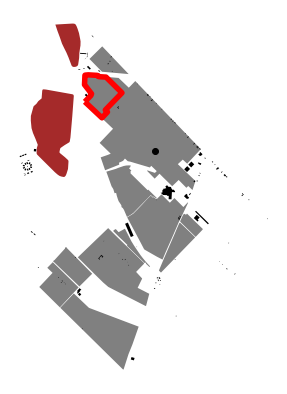

In [8]:
f, ax = plt.subplots(figsize=(12,7))

# preparamos nuestros layers
vh_polyg = vh[vh.geometry.apply(lambda x: x.type == 'Polygon')] # nos quedamos con la entidad que es un polígono!
usos_residenciales = usos_suelo.loc[usos_suelo.landuse == 'residential']
basurales = usos_suelo.loc[usos_suelo.landuse == 'landfill']

# ploteamos
usos_residenciales.plot(ax=ax, color='grey')
vh_polyg.geometry.boundary.plot(ax=ax, color='red', linewidth=5.5)
basurales.plot(ax=ax, color='brown')
edificios.plot(ax=ax, color='black')

ax.set_axis_off();

### Variando las referencias de nuestra consulta

Ahora que tenemos una idea de cómo funciona una consulta con OSMnx, traigamos distintos servicios que nos permitan construir centros de actividad en el partido. 

Decíamos que la idea de centralidad hace mención a servicios que suceden juntos. El tag `amenity` es un buen punto de partida para esto. 

#### Consultas a partir de un nombre

In [9]:
# si quisieramos traer algunas categorias
tags = {'amenity':['taxi','bank','cafe','bar',
                   'restaurant', 'university', 
                   'community_centre']}
#o simplemente todas
tags = {'amenity':True} # esta es la que vamos a estar usando

referencia = 'Partido de General San Martin, Buenos Aires, Argentina'

gdf = ox.geometries_from_place(query=referencia, tags=tags)
gdf.shape 

(713, 125)

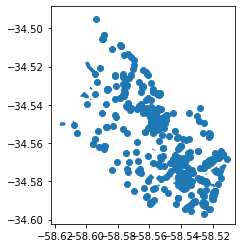

In [10]:
gdf.plot();

In [11]:
# tambien podemos buscar por el tipo de distrito
partido = 'Partido de General San Martín, Buenos Aires, Argentina'
tags = {'type': 'boundary'} 

sm = ox.geometries_from_place(partido, tags)
sm.shape

/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


(36, 95)

In [12]:
sm.name.unique()

array(['Buenos Aires', 'Vicente López', 'Villa Martelli', 'Villa Adelina',
       'Florida Oeste', 'Munro', 'Partido de General San Martín',
       'Partido de Tres de Febrero', 'Partido de San Isidro',
       'Boulogne Sur Mer', 'Don Torcuato', 'Villa Devoto',
       'Villa Pueyrredón', 'Partido de Tigre', 'Partido de San Miguel',
       'Sáenz Peña', 'El Libertador', 'Loma Hermosa', 'Villa Bosch',
       'Santos Lugares', 'Caseros', 'Campo de Mayo',
       'Partido de Vicente López', 'Ciudad Autónoma de Buenos Aires',
       'Comuna 12', 'Comuna 11', 'José León Suárez', 'Villa Ballester',
       'San Andrés', 'Villa Maipú', 'General San Martín', 'Villa Lynch',
       'Billinghurst'], dtype=object)

In [13]:
sm[sm.name.isin(['Partido de General San Martín', 'General San Martín'])].reset_index()

,element_type,osmid,geometry,admin_level,alt_name:gl,name,name:ar,name:be,name:bg,name:de,...,name:sk,name:sr-Latn,name:sw,name:tt,name:vi,name:vo,official_name:sr,official_name:sr-Latn,official_name:ru,timezone
0,relation,1719022,"POLYGON ((-58.61822 -34.54743, -58.61750 -34.5...",5,NaN,Partido de General San Martín,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,relation,9168783,"POLYGON ((-58.54779 -34.57602, -58.54766 -34.5...",8,NaN,General San Martín,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


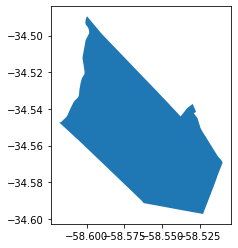

In [14]:
# asi podemos construir el limite del partido
sm[sm.name.isin(['Partido de General San Martín', 'General San Martín'])].reset_index().iloc[0:1].plot();

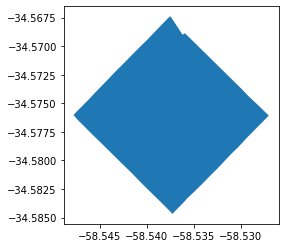

In [15]:
# o el de la localidad o distrinto central
sm[sm.name.isin(['Partido de General San Martín', 'General San Martín'])].reset_index().iloc[1:2].plot();

In [16]:
limite_partido = sm[sm.name.isin(['Partido de General San Martín'])].copy()
distrito_central = sm[sm.name.isin(['General San Martín'])].copy()
centroide = distrito_central.geometry.centroid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


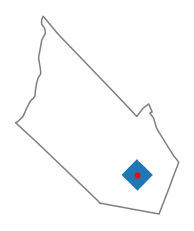

In [17]:
# estas son las capas de contexto con las que vamos a estar trabajando. Todas las construimos desde OSMnx
f, ax = plt.subplots()
limite_partido.geometry.boundary.plot(ax=ax, edgecolor='grey')
distrito_central.plot(ax=ax)
centroide.plot(ax=ax, markersize=25, color='red')
ax.set_axis_off();

#### Consultas a partir de un punto de referencia

In [18]:
ox.geometries_from_point?

In [19]:
# definimos como referencia el centroide del distrito central
referencia = (centroide.geometry.y.values[0],centroide.geometry.x.values[0])

In [20]:
referencia

(-34.57607330769201, -58.53744356860958)

Y establecemos una referencia para hacer la consulta ...

In [21]:
# area en km2 del distrito central
km2 = distrito_central.to_crs(3857).geometry.area.values/1000000 #pasamos de m2 a km2
print('La localidad de General San Martin tiene una superficie de {} km2'.format(round(km2[0],2)))

La localidad de General San Martin tiene una superficie de 2.69 km2


In [22]:
# calculamos la raiz cuadrada para obtener el largo de los lados del cuadrado
longitud = km2[0]**0.5
print('El area del distrito central es de {} km*{} km'.format(round(longitud,2), round(longitud,2))) 

El area del distrito central es de 1.64 km*1.64 km


In [23]:
# multiplicamos por mil para pasar de km2 a mts lineales. 
print('Un radio razonable para el buffer podria ser de {} mts'.format(round((longitud/2)*1000,2))) 

Un radio razonable para el buffer podria ser de 820.16 mts


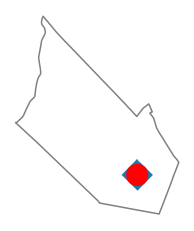

In [24]:
f, ax = plt.subplots()
limite_partido.to_crs(3857).geometry.boundary.plot(ax=ax, edgecolor='grey')
distrito_central.to_crs(3857).plot(ax=ax)
centroide.to_crs(3857).buffer(820).plot(ax=ax, markersize=1, color='red')

ax.set_axis_off();

In [25]:
# una buena referencia podria ser un buffer de mil metros!
tags = {'amenity':True}
gdf_ = ox.geometries_from_point(center_point=referencia, dist=1000, tags=tags)
gdf_.shape

(203, 90)

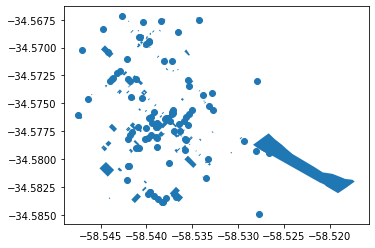

In [26]:
# vemos que tenemos poligonos y puntos
gdf_.plot();

## 2. DBSCAN: Identificando centros de actividad

In [27]:
import numpy as np
from sklearn.cluster import DBSCAN

Para identificar clusters con las geometrías que consultamos, vamos a trabajar con la implementación de [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) que ofrece scikit learn.

Sus siglas vienen de `Density-based Spatial Clustering of Applications with Noise`, lo que ya nos da alguna pista sobre su funcionamiento. Este algoritmo determina categorías de agrupamiento a partir de cuan densa es un área en términos de la concentración de puntos (o coordenadas) existentes. Cuan denso estará determinado por dos parametros principales: `eps` y `min_samples`. 

Para mayor información pueden leer la página de [Wikipedia](https://es.wikipedia.org/wiki/DBSCAN). Si quieren explorar otros algoritmos de clustering, les dejamos [este articulo](https://towardsdatascience.com/clustering-in-geospatial-applications-which-model-should-you-use-59a039332c45).


<figure>
<center>
<img src='https://drive.google.com/uc?id=1mCaIGA8rWLRAkhDd9WRcyj1OOV6wyUNz' />
<figcaption></figcaption></center>
</figure>

### 2.1. Clusters en el partido de San Martín

In [28]:
from google.colab import drive

In [29]:
drive.mount('/drive/')

Mounted at /drive/


In [30]:
# cargamos algunas capas de contexto extra
manzanas = gpd.read_file('/drive/MyDrive/Gestion de ciudades/data/clustering/Polyg_371.zip')
localidades = gpd.read_file('/drive/MyDrive/Gestion de ciudades/data/clustering/localidades.geojson')

In [31]:
len(gdf[gdf.geometry.apply(lambda x: x.type != 'Polygon')])

455

In [32]:
gdf[gdf.geometry.apply(lambda x: x.type != 'Polygon')]['amenity'].unique()

array(['fuel', 'police', 'school', 'bar', 'pharmacy', 'parking_entrance',
       'bank', 'fast_food', 'cafe', 'clinic', 'atm', 'telephone',
       'post_box', 'recycling', 'kindergarten', 'car_wash', 'parking',
       'post_office', 'prison', 'university', 'fire_station',
       'restaurant', 'library', 'place_of_worship', 'bench', 'hospital',
       'taxi', 'ice_cream', 'events_venue', 'courthouse', 'pub',
       'doctors', 'dentist', 'veterinary', 'internet_cafe',
       'payment_centre', 'driving_school', 'community_centre', 'theatre',
       'drinking_water', 'love_hotel', 'toilets', 'public_bookcase',
       'vending_machine', 'ticket_validator'], dtype=object)

In [33]:
# nos quedamos solo con los puntos
gdf_puntos = gdf[gdf.geometry.apply(lambda x: x.type != 'Polygon')].copy()

In [34]:
gdf_puntos.geometry.crs.is_geographic

True

Existen dos caminos para estimar clusters con DBSCAN, trabajando con coordenadas geográficas o proyectadas.

**1. Reproyectando nuestras coordenadas**

In [35]:
#lo pasamos a una proyeccion con unidades de medida en metros para usar distancia euclidiana
gdf_puntos_mts = gdf_puntos.to_crs(epsg = 3857)
#extraemos esas coordenadas en metros
gdf_puntos_mts['x'] = gdf_puntos_mts.geometry.x
gdf_puntos_mts['y'] = gdf_puntos_mts.geometry.y

#construimos las coordenadas en el formato que requiere DBSCAN
X = gdf_puntos_mts.reindex(columns = ['x','y']).values

#construimos el objeto DBSCAN con nuestros dos parametros 
clustering = DBSCAN(eps=1000, #la distancia minima entre servicios para considerarlos "cerca"
                    min_samples=50 # la cantidad minima de actividades o servicios en un grupo
                    ).fit(X)
# guardamos la clasificacion en una columna en nuestro dataframe. -1 es en ningun grupos significativo
gdf_puntos_mts.loc[:,'k'] = clustering.labels_

#vemos una distirbucion de frecuencias para ver cantidad de estaciones dentro de cada grupo
gdf_puntos_mts['k'].value_counts(normalize = True) * 100

-1    48.131868
 1    26.593407
 0    25.274725
Name: k, dtype: float64

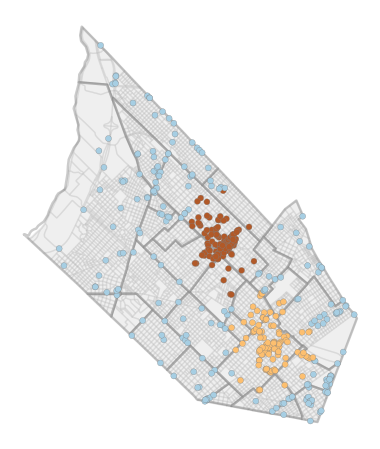

In [36]:
#visualizamos en un mapa
f,ax = plt.subplots(figsize = (8,8))
manzanas.to_crs(3857).plot(ax=ax, color='grey', edgecolor='grey', linewidth=1.5, alpha = 0.2)
localidades.to_crs(3857).plot(ax=ax, color='white', edgecolor='grey', linewidth=2.5, alpha = 0.4)
gdf_puntos_mts.plot(column = 'k',ax=ax, categorical = True, cmap='Paired', edgecolor='grey', linewidth=0.3)

ax.set_axis_off()

**2. Sin reproyectar, trabajando con radianes**

In [37]:
DBSCAN?

In [38]:
# creamos coordenadas
gdf_puntos['x'] = gdf_puntos.geometry.x
gdf_puntos['y'] = gdf_puntos.geometry.y

También existe la posibilidad de utilizar una distancia de ['Haversine'](https://www.ehowenespanol.com/calcular-distancia-puntos-latitud-longitud-como_452715/) para calcular la distancia entre dos puntos siguiendo el radio de la esfera/Tierra.

El parámetro `algorithm` puede recibir distintos valores. Para establecer relaciones de vecindad se pueden usar varios (aca la documentacion oficial sobre el módulo [NearestNeighbors](https://scikit-learn.org/stable/modules/neighbors.html) que realiza esta tarea). En este [articulo](https://towardsdatascience.com/tree-algorithms-explained-ball-tree-algorithm-vs-kd-tree-vs-brute-force-9746debcd940) tambien pueden encontrar algunas definiciones mas detalladas. 

Nosotros vamos a explorar dos, el que viene por default y `ball-tree` que nos permite trabajar con la distancia haversine. Por default, el parámetro `metric` determina distancia euclideana en mts.

In [39]:
# establecemos el formato requerido con latitud y longitud
coords = gdf_puntos.reindex(columns=['y', 'x']).values

# cantidad de km en un radian. Esta es la medida de la haversine distance
kms_per_radian = 6371.0088

# definamos un epsilon de mil metros. Es necesario convertir a radianes para tranajar con haversine
epsilon = 1 / kms_per_radian

db = DBSCAN(eps=epsilon, 
            min_samples=50, 
            algorithm='ball_tree', 
            metric='haversine').fit(np.radians(coords))

cluster_labels = db.labels_
unique_labels = set(cluster_labels)

# obtenemos el numero de clusters
num_clusters = len(set(cluster_labels))

In [40]:
num_clusters

3

In [41]:
cluster_labels

array([-1, -1,  0,  0,  0,  0, -1,  1,  0,  1,  1,  1,  1,  0,  0, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0, -1,
       -1, -1,  1,  0,  0,  0,  0, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1,  0,  0,  1,  1, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1,  0,  0,
       -1,  1,  1,  1,  1,  1,  1,  0,  0, -1,  0,  0, -1,  0,  0,  0, -1,
       -1,  0,  0,  1,  1,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1, -1,  0,  0, -1, -1,  0,  1,  1,  0,  0,
        1,  0,  0,  0,  1

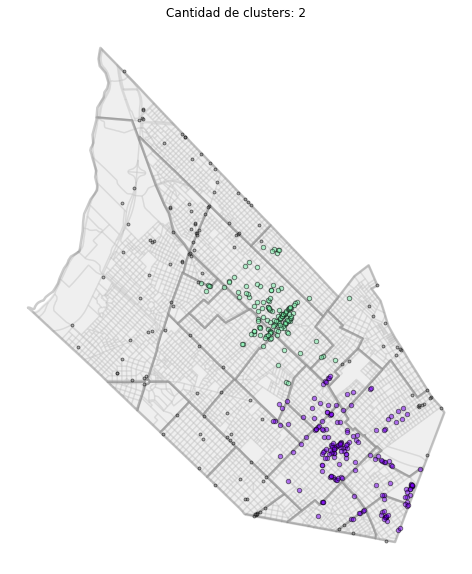

In [42]:
fig, ax = plt.subplots(figsize=(10,10))
# construimos colores para cada cluster, a partir del len de unique labels
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# capas de contexto
manzanas.to_crs(4326).plot(ax=ax, color='grey', edgecolor='grey', linewidth=1.5, alpha = 0.2)
localidades.to_crs(4326).plot(ax=ax, color='white', edgecolor='grey', linewidth=2.5, alpha = 0.4)

# para cada cluster label y color, ploteamos un punto
for cluster_label, color in zip(unique_labels, colors):
    
    size = 20
    if cluster_label == -1: # hacemos que los puntos atípicos (-1) se vean grises y más chicos
        color = 'gray'
        size = 8
    
    # ploteamos los puntos que matchean en cada cluster label
    x_coords = coords[cluster_labels==cluster_label][:,1]
    y_coords = coords[cluster_labels==cluster_label][:,0]
    ax.scatter(x=x_coords, y=y_coords, color=color, edgecolor='k', s=size, alpha=0.5)

ax.set_title('Cantidad de clusters: {}'.format(num_clusters-1))
ax.patch.set_facecolor('#F7F7F7')
ax.axis('off')
plt.show();

### 2.2. Clusters en la localidad de General San Martin

In [43]:
# nos quedamos solo con los puntos en el distrito de san martin
gdf_puntos_ = gdf_[gdf_.geometry.apply(lambda x: x.type != 'Polygon')].copy()

In [44]:
gdf_puntos_mts_ = gdf_puntos_.to_crs(epsg = 3857)
gdf_puntos_mts_['x'] = gdf_puntos_mts_.geometry.x
gdf_puntos_mts_['y'] = gdf_puntos_mts_.geometry.y

X_ = gdf_puntos_mts_.reindex(columns = ['x','y']).values

clustering_ = DBSCAN(eps=100, 
                     min_samples=5 
                     ).fit(X_)

gdf_puntos_mts_.loc[:,'k'] = clustering_.labels_

gdf_puntos_mts_['k'].value_counts(normalize = True) * 100

-1    68.750000
 1    16.666667
 2     8.333333
 0     6.250000
Name: k, dtype: float64

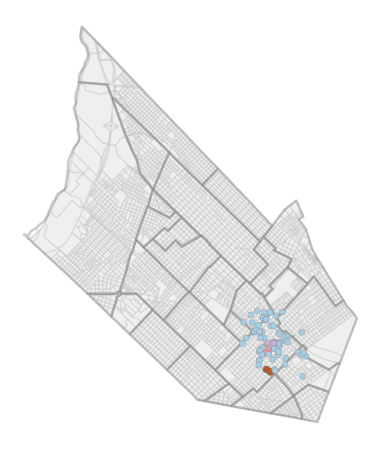

In [46]:
#visualizamos los tres clusters
f,ax = plt.subplots(figsize = (8,8))
manzanas.to_crs(3857).plot(ax=ax, color='grey', edgecolor='grey', linewidth=1.5, alpha = 0.2)
localidades.to_crs(3857).plot(ax=ax, color='white', edgecolor='grey', linewidth=2.5, alpha = 0.4)

gdf_puntos_mts_.plot(column = 'k',ax=ax, categorical = True, cmap='Paired', edgecolor='grey', linewidth=0.3)

ax.set_axis_off()

# Ejercitación sugerida

### Economías de aglomeración en el partido de San Martín

A continuación compartimos [la siguiente publicación](http://www.unsam.edu.ar/escuelas/economia/ceeu/archivos/EEU_N03_PAE_ISSN_VF.pdf) que realizamos hace algún tiempo desde el [CEEU](http://www.unsam.edu.ar/escuelas/economia/ceeu/). En la misma identificamos clusters productivos en la que se dice la capital pyme del país. Si, el partido de General San Martín. 


In [47]:
from google.colab import drive

In [48]:
drive.mount('/drive/')

Drive already mounted at /drive/; to attempt to forcibly remount, call drive.mount("/drive/", force_remount=True).


In [49]:
df = pd.read_csv('/drive/MyDrive/Gestion de ciudades/data/clustering/sm_industrias.csv')

In [50]:
df

,cuit,latitude,longitude,rama,etiqueta,sub_rama
0,0,-34.556458,-58.540351,SERVICIOS,FABRICACION DE PRODUCTOS ELABORADOS DE METAL N...,METALES
1,1,-34.575951,-58.537270,SERVICIOS,FABRICACION DE PRODUCTOS ELABORADOS DE METAL N...,METALES
2,2,-34.567053,-58.512032,FABRICACION,"FABRICACION DE PARTES, PIEZAS Y ACCESORIOS PAR...",AUTOMOTORES
3,3,-34.584687,-58.523339,SERVICIOS,FABRICACION DE PRODUCTOS ELABORADOS DE METAL N...,METALES
4,4,-34.568032,-58.582635,FABRICACION,"FABRICACION DE HILADOS Y TEJIDOS, ACABADO DE P...",TEXTILES
...,...,...,...,...,...,...
1390,1390,-34.556499,-58.536108,FABRICACION,"INDUSTRIAS BASICAS DE HIERRO Y ACERO', '",METALES
1391,1391,-34.579071,-58.528872,FABRICACION,"FABRICACION DE PRODUCTOS TEXTILES N.C.P.', '",TEXTILES
1392,1392,-34.540539,-58.544714,FABRICACION,"FABRICACION DE SUSTANCIAS QUIMICAS BASICAS', '",PRODUCTOS QUIMICOS
1393,1393,-34.584886,-58.532329,FABRICACION,"FABRICACION DE PRODUCTOS TEXTILES N.C.P.', '",TEXTILES


**Les proponemos que:**

1. Intenten armar `n` clusters para las industrias del partido de San Martín. Ven alguna similitud con el patrón territorial que distinguimos con servicios?

2. Elijan una rama o subrama, filtren para alguna categoría de interés y traten de obtener los `n` clusters que consideren apropiados.

3. Revisen la etiqueta y fíjense si existe alguna categoría que les resulte de particular interés. Puede armar clusters para esta?